In [2]:
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
import copy
import random
from collections import defaultdict

import energyflow
from particle import Particle
import pennylane as qml
from tqdm import tqdm

import torch
import torch.nn as nn
from torch_geometric.nn import GCNConv
from torch.nn import Linear, ReLU, Sigmoid, ModuleList, LeakyReLU
from torch_geometric.nn import global_mean_pool
from torch_geometric.utils import add_self_loops, degree
from torch_geometric.data import Data, Dataset
from torch.utils.data import Dataset
from torch_geometric.utils import to_networkx
from torch.optim import Adam
from torch_geometric.loader import DataLoader
from torch_geometric.utils import subgraph


from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, roc_curve

import wandb

In [3]:
os.chdir('..');
print(os.getcwd())
from qssl.loss.losses import ContrastiveLoss
from qssl.data.data_loader import preprocess_fixed_nodes
from qssl.utils.utils import visualize_graph_pairs, visualize_graph_pairs_01, plot_and_save_loss

C:\Users\Sanya Nanda\Sanya-Home\gsoc2024\ML4Sci_QuantumContrastiveLearning


In [1]:
n_connections = 8
input_dims = 8
hidden_dims = [32,16,8]
output_dims = 4
q_depth = 1
epochs = 20
lr = 1e-3
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1
batch_size = 1000

In [5]:
X = np.load(r'data/qg_graph/x10_sorted_12500.npy')
y = np.load(r'data/qg_graph/y10_sorted_12500.npy')
N=12500

In [6]:
x_data, y_data, edge_tensor, edge_indx_tensor, edge_attr_matrix, graph_help = preprocess_fixed_nodes(X,y)

--- Finding All Unique Particles ---

--- Inserting Masses ---


14it [00:00, 229.97it/s]


--- Calculating Momenta and Energies ---



--- Calculating Edge Tensors ---


100%|███████████████████████████████████████████████████████████████████████████| 12500/12500 [00:15<00:00, 814.54it/s]


In [7]:
print('----- Check for the correctly sized tensors -----')
print()
print(f'Jet Data: {x_data.shape}')
print(f'Classification: {y_data.shape}')
print(f'Full Edge Information: {edge_tensor.shape}')
print(f'Edge Index Information: {edge_indx_tensor.shape}')
print(f'Edge Attribute Information: {edge_attr_matrix.shape}')
print(f'Graph Structure Information: {graph_help.shape}')
print('\n')
print('----- Check that each tensor is normalized -----')
print()
print(f'Jet Data max: {torch.max(x_data)}')
print(f'Classification Max: {torch.max(y_data)}')
print(f'Edge Length Max: {torch.max(edge_tensor)}')

----- Check for the correctly sized tensors -----

Jet Data: torch.Size([12500, 10, 8])
Classification: torch.Size([12500])
Full Edge Information: torch.Size([12500, 10, 10])
Edge Index Information: torch.Size([12500, 2, 90])
Edge Attribute Information: torch.Size([12500, 90, 1])
Graph Structure Information: torch.Size([12500, 4])


----- Check that each tensor is normalized -----

Jet Data max: 1.0
Classification Max: 1
Edge Length Max: 1.0


In [8]:
print('----- Check the structure of the dataset -----')
print()
print(f'Number of graphs (jets): {x_data.shape[0]}')
print(r'Number of features per node (p_T(M),y,phi,m,E,px,py,pz): '+f'{x_data.shape[2]}')
print(f'Number of classes (2: Quarks or Gluons): {np.unique(y_data).shape[0]}')
print()
print('----- Check the structure of one graph -----')
print()
i=0
number_of_edges = graph_help[i,3]
# Gather some statistics about the first graph.
print(f'Number of nodes (particle IDs): {x_data[i,:,0].shape[0]}')
print(f'Number of edges: {number_of_edges}')
print(f'Average node degree: {number_of_edges / x_data[i,:,0].shape[0]:.2f}')
print(f'Is undirected: {True}')

----- Check the structure of the dataset -----

Number of graphs (jets): 12500
Number of features per node (p_T(M),y,phi,m,E,px,py,pz): 8
Number of classes (2: Quarks or Gluons): 2

----- Check the structure of one graph -----

Number of nodes (particle IDs): 10
Number of edges: 90.0
Average node degree: 9.00
Is undirected: True


In [9]:
# Create a dataset class
class Create_Dataset(Dataset):
    def __init__(self, edge_index, x, edge_attr, y, graph_info, transform=None):
        self.edge_index = edge_index
        self.x          = x
        self.edge_attr  = edge_attr
        self.y          = y
        self.graph_info = graph_info
        self.transform  = transform

    def __len__(self):
        return self.y.shape[0]
        
    def __getitem__(self, index):
        sample = {'edge_index': self.edge_index[index,:,:self.graph_info[index,3]],
                'x': self.x[index,:int(self.graph_info[index,2]),:],
                'edge_attr': self.edge_attr[index,:self.graph_info[index,3]],
                'y': self.y[index] }

        if self.transform is not None:
            sample = self.transform(sample)
        return sample

In [10]:
train_index   = int(N*0.8)
val_index    = int(N*0.9)
dataset = []
for i in tqdm(range(N)):
    dataset.append(Data(edge_index=edge_indx_tensor[i,:,:],
                        x=x_data[i,:,:],
                        edge_attr=edge_attr_matrix[i,:],
                        y=y_data[i]))

original_dataset = dataset

100%|██████████████████████████████████████████████████████████████████████████| 12500/12500 [00:01<00:00, 9229.29it/s]


In [11]:
# Function to randomly drop nodes in a graph
def drop_nodes(data, drop_prob=0.2):
    node_mask = torch.rand(data.x.size(0)) > drop_prob
    data.x = data.x[node_mask]
    data.edge_index, _ = subgraph(node_mask, data.edge_index, relabel_nodes=True)
    return data

# Function to randomly drop edges in a graph
def drop_edges(data, drop_prob=0.2):
    edge_mask = torch.rand(data.edge_index.size(1)) > drop_prob
    data.edge_index = data.edge_index[:, edge_mask]
    return data

# Function to randomly mask node features in a graph
def mask_features(data, mask_prob=0.2):
    feature_mask = torch.rand(data.x.size()) > mask_prob
    data.x = data.x * feature_mask.float()
    return data

In [12]:
# Define the augmentation function
def graph_augment(data):
    # Example augmentation: randomly drop nodes, edges, and mask features
    data_aug = data.clone()
    data_aug = drop_nodes(data_aug, drop_prob=0.1)
    # data_aug = drop_edges(data_aug, drop_prob=0.1)
    data_aug = mask_features(data_aug, mask_prob=0.1)
    return data_aug

def create_contrastive_pairs(dataset):
    pairs = []
    labels = []
    # Group graphs by their labels (0 or 1)
    label_to_graphs = defaultdict(list)
    for data in dataset:
        label_to_graphs[data.y.item()].append(data)

    # Create pairs for positive class
    for data in label_to_graphs[1]:  # For each positive graph
        data_aug = graph_augment(data)  # Create an augmented version
        pairs.append((data, data_aug))  # Add the original and augmented graph as a pair
        labels.append(1)  # Label 1 for positive pair (similar)

    # Create pairs for negative class
    for data in label_to_graphs[0]:  # For each negative graph
        data_aug = graph_augment(data)  # Create an augmented version
        pairs.append((data, data_aug))  # Add the original and augmented graph as a pair
        labels.append(0)  # Label 0 for negative pair (dissimilar)

    return pairs, labels


In [13]:
pairs, labels = create_contrastive_pairs(dataset)

In [14]:
run = wandb.init(
    project = "ML4Sci-QuantumContrastiveLearning",
    config = {
        "dataset":"QG12500",
        "model":"Base Classical GNN",
        "loss":"contrastive pair loss"
    }
)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin


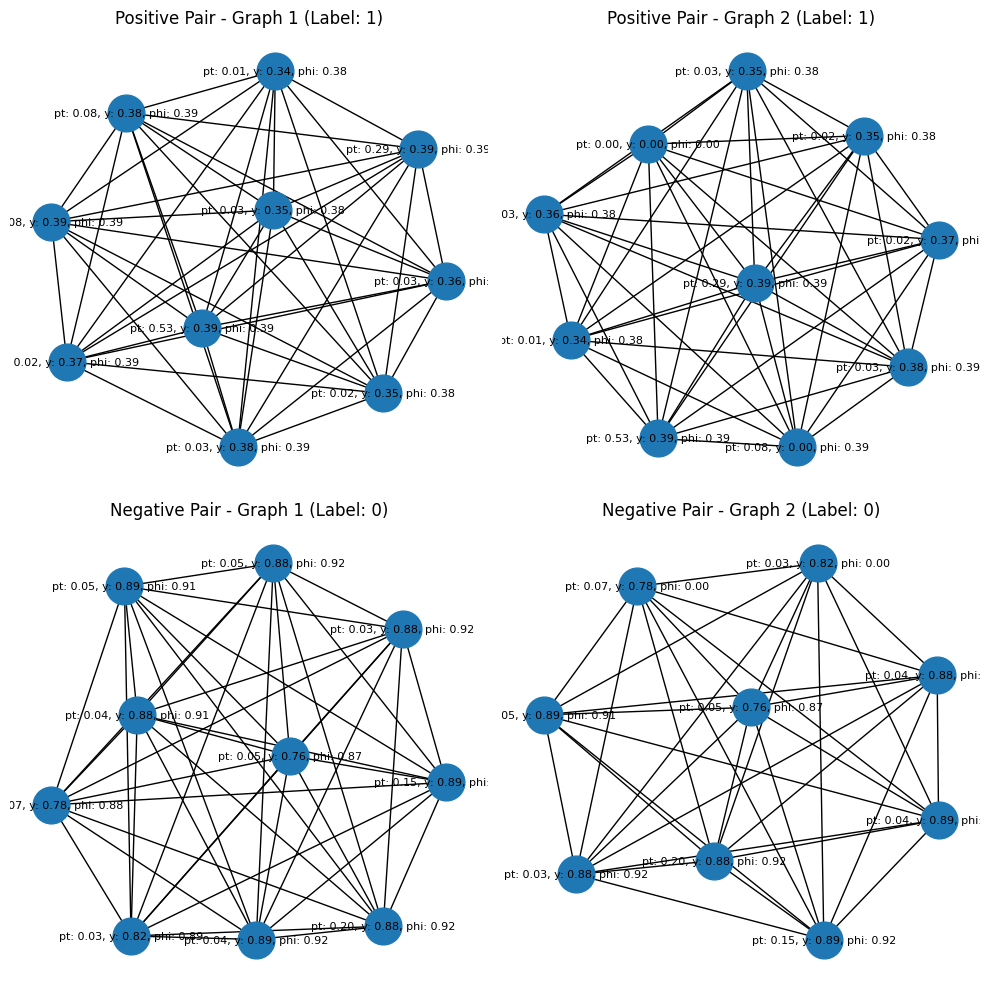

In [15]:
visualize_graph_pairs_01(pairs, labels)

In [16]:
class GraphPairDataset(Dataset):
    def __init__(self, pairs, labels):
        self.pairs = pairs  
        self.labels = labels 
        
    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        graph1, graph2 = self.pairs[idx]
        label = self.labels[idx]
        return graph1, graph2, label

In [17]:
import torch
from sklearn.model_selection import train_test_split

def split_pairs(pairs, labels, train_ratio, val_ratio):
    train_pairs, temp_pairs, train_labels, temp_labels = train_test_split(
        pairs, labels, train_size=train_ratio, random_state=42, stratify=labels
    )
    val_pairs, test_pairs, val_labels, test_labels = train_test_split(
        temp_pairs, temp_labels, test_size=0.5, random_state=42, stratify=temp_labels
    )
    
    return train_pairs, train_labels, val_pairs, val_labels, test_pairs, test_labels

train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

train_pairs, train_labels, val_pairs, val_labels, test_pairs, test_labels = split_pairs(
    pairs, labels, train_ratio, val_ratio
)

In [18]:
# Now, create datasets and dataloaders for each split
train_dataset = GraphPairDataset(train_pairs, train_labels)
val_dataset = GraphPairDataset(val_pairs, val_labels)
test_dataset = GraphPairDataset(test_pairs, test_labels)

batch_size = 1000

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [19]:
train_dataset[0][0].edge_index

tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2,
         2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5,
         5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7,
         8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 3, 4, 5, 6,
         7, 8, 9, 0, 1, 2, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 5, 6, 7, 8, 9, 0, 1, 2,
         3, 4, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 8, 9,
         0, 1, 2, 3, 4, 5, 6, 7, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8]])

In [20]:
train_dataset[0][1].edge_index

tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2,
         2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5,
         5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7,
         8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 3, 4, 5, 6,
         7, 8, 9, 0, 1, 2, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 5, 6, 7, 8, 9, 0, 1, 2,
         3, 4, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 8, 9,
         0, 1, 2, 3, 4, 5, 6, 7, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8]])

In [21]:
train_dataset[0]

(Data(x=[10, 8], edge_index=[2, 90], edge_attr=[90, 1], y=1),
 Data(x=[10, 8], edge_index=[2, 90], edge_attr=[90, 1], y=1),
 1)

In [22]:
# Check a sample from the dataloader
for data1, data2, label in train_dataloader:
    print(data1)
    print(data2)
    print(label)
    break

DataBatch(x=[10000, 8], edge_index=[2, 90000], edge_attr=[90000, 1], y=[1000], batch=[10000], ptr=[1001])
DataBatch(x=[9065, 8], edge_index=[2, 73966], edge_attr=[90000, 1], y=[1000], batch=[9065], ptr=[1001])
tensor([0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1,
        1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1,
        0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1,
        1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0,
        0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0,
        1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1,
        1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1,
        1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1,
        1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1,

In [23]:
from torch_geometric.nn import GATConv, global_mean_pool, GraphConv
from torch.nn import ModuleList, Linear, ReLU
import torch


class GNN(torch.nn.Module):
    def __init__(self, input_dims, hidden_dims, output_dims, activ_fn):
        super().__init__()
        layers = []
        layers.append(GATConv(input_dims, hidden_dims[0]))
    
        for i in range(len(hidden_dims)-1):
            layers.append(GATConv(hidden_dims[i], hidden_dims[i+1]))
            
        self.layers = ModuleList(layers)
        self.activ_fn = activ_fn
        self.readout_layer = Linear(hidden_dims[-1], output_dims)  # No final classifier, just embeddings
        self.dropout = torch.nn.Dropout(p=0.5)  


    def forward(self, x, edge_index, batch):
        h = x
        for i in range(len(self.layers)):
            h = self.layers[i](h, edge_index)
            h = self.activ_fn(h)
            h = self.dropout(h)  
         
        h = global_mean_pool(h, batch) # Readout layer to get the embedding for each graph in batch
        return h  # Return the graph embeddings

In [24]:
def run_model(model, epoch, dataloader, lossFn, optimizer=None, train=True):
    if train:
        model.train()
    else:
        model.eval()

    total_loss = 0
    correct = 0
    num_samples = 0

    for batch in dataloader:
        optimizer.zero_grad() if train else None

        # Extract the pairs and labels from the dataloader batch
        data1, data2, labels = batch[0], batch[1], batch[2]
        
        # Get the embeddings for both graphs
        emb1 = model(data1.x.float(), data1.edge_index, data1.batch)
        emb2 = model(data2.x.float(), data2.edge_index, data2.batch)
        
        # Compute contrastive loss
        loss = lossFn(emb1, emb2)  
        
        if train:
            loss.backward()
            optimizer.step()

        total_loss += loss.item() * data1.num_graphs
        num_samples += data1.num_graphs

    avg_loss = total_loss / num_samples
    return avg_loss


In [25]:
def train_model(model, optimizer, lossFn, epochs, lr, train_dataloader, val_dataloader):
    history = {'train_loss': [], 'val_loss': []}

    for epoch in range(epochs):
        # Run training
        train_loss = run_model(model, epoch, train_dataloader, lossFn, optimizer)
        
        # Run validation
        val_loss = run_model(model, epoch, val_dataloader, lossFn, optimizer=None, train=False)
        
        print(f"Epoch {epoch + 1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

        # Store loss for this epoch
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        
        # Log losses to WandB
        wandb.log({
            "epoch": epoch + 1,
            "train_loss": train_loss,
            "val_loss": val_loss
        })

    return history

In [26]:
model = GNN(input_dims,hidden_dims,output_dims, activ_fn=ReLU())
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
lossFn = ContrastiveLoss(margin=1, mode='pairs')  # Use contrastive loss in pair mode
history = train_model(model, optimizer, lossFn=lossFn, epochs=50, lr=0.001, train_dataloader=train_dataloader, val_dataloader=val_dataloader)


Epoch 1, Train Loss: 0.9590, Val Loss: 0.9628
Epoch 2, Train Loss: 0.9076, Val Loss: 0.9250
Epoch 3, Train Loss: 0.8251, Val Loss: 0.8651
Epoch 4, Train Loss: 0.7079, Val Loss: 0.7732
Epoch 5, Train Loss: 0.5638, Val Loss: 0.6636
Epoch 6, Train Loss: 0.4192, Val Loss: 0.5622
Epoch 7, Train Loss: 0.2858, Val Loss: 0.4777
Epoch 8, Train Loss: 0.1886, Val Loss: 0.4156
Epoch 9, Train Loss: 0.1182, Val Loss: 0.3678
Epoch 10, Train Loss: 0.0729, Val Loss: 0.3307
Epoch 11, Train Loss: 0.0452, Val Loss: 0.3022
Epoch 12, Train Loss: 0.0297, Val Loss: 0.2798
Epoch 13, Train Loss: 0.0218, Val Loss: 0.2618
Epoch 14, Train Loss: 0.0173, Val Loss: 0.2478
Epoch 15, Train Loss: 0.0145, Val Loss: 0.2367
Epoch 16, Train Loss: 0.0129, Val Loss: 0.2279
Epoch 17, Train Loss: 0.0119, Val Loss: 0.2208
Epoch 18, Train Loss: 0.0113, Val Loss: 0.2150
Epoch 19, Train Loss: 0.0109, Val Loss: 0.2101
Epoch 20, Train Loss: 0.0106, Val Loss: 0.2059
Epoch 21, Train Loss: 0.0104, Val Loss: 0.2024
Epoch 22, Train Loss: 

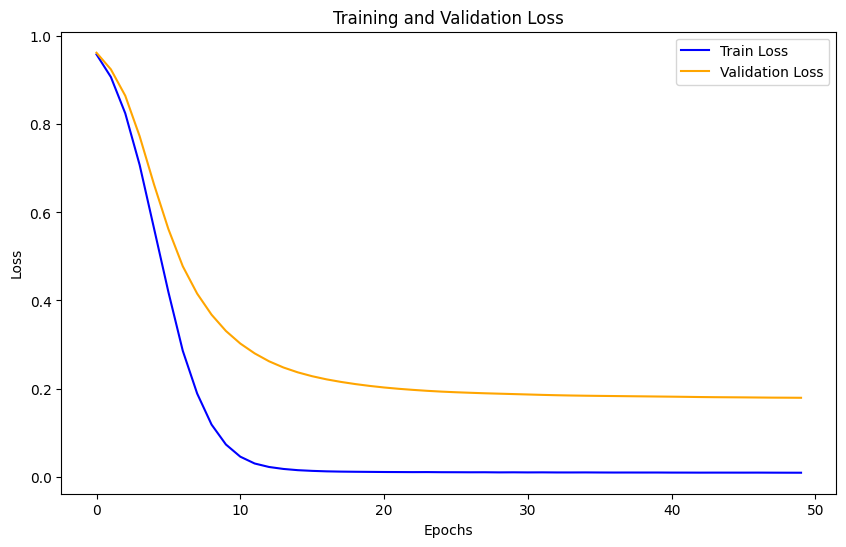

In [27]:
plot_and_save_loss(history)

### LCT: Linear Classification Test

In [28]:
def run_model_lct(model, epoch, dataloader, lossFn, optimizer=None, train=True, return_embeddings=False):
    if train:
        model.train()
    else:
        model.eval()

    total_loss = 0
    correct = 0
    num_samples = 0
    all_embeddings = []
    all_labels = []

    for batch in dataloader:
        optimizer.zero_grad() if train else None

        # Extract the pairs and labels from the dataloader batch
        data1, data2, labels = batch[0], batch[1], batch[2]
        
        # Get the embeddings for both graphs
        emb1 = model(data1.x.float(), data1.edge_index, data1.batch)
        emb2 = model(data2.x.float(), data2.edge_index, data2.batch)
        
        if return_embeddings:
            # Save embeddings and labels for later use in classification
            all_embeddings.append(emb1.detach().cpu())
            all_labels.append(labels.detach().cpu())

        # Compute contrastive loss
        loss = lossFn(emb1, emb2)
        
        if train:
            loss.backward()
            optimizer.step()

        total_loss += loss.item() * data1.num_graphs
        num_samples += data1.num_graphs

        # Compute accuracy
        with torch.no_grad():
            cos_sim = torch.nn.functional.cosine_similarity(emb1, emb2)
            predictions = (cos_sim > 0.5).long()  # You can adjust the threshold
            correct += (predictions == labels).sum().item()

    avg_loss = total_loss / num_samples
    accuracy = correct / num_samples

    if return_embeddings:
        return torch.cat(all_embeddings, dim=0), torch.cat(all_labels, dim=0)
    return avg_loss, accuracy


In [29]:
# training_data = original_dataset[:train_index]
# val_data      = original_dataset[train_index:val_index]
# test_data     = original_dataset[val_index:]

# # Create data loaders
# train_loader = DataLoader(training_data,
#                               batch_size = batch_size,
#                               shuffle = True,
#                               num_workers = 0)

# val_loader  = DataLoader(val_data,
#                               batch_size = batch_size,
#                               shuffle = False,
#                               num_workers = 0)

# test_loader  = DataLoader(test_data,
#                               batch_size = batch_size,
#                               shuffle = False,
#                               num_workers = 0)

# print(f'Number of training graphs: {train_index}')
# print(f'Number of validation graphs: {val_index-train_index}')
# print(f'Number of test graphs: {N-val_index}')

In [30]:
# After training, use the run_model function to extract embeddings from the validation/test dataset
train_embeddings, train_labels = run_model_lct(model, epoch=0, dataloader=train_dataloader, lossFn=lossFn, return_embeddings=True, train=False)
test_embeddings, test_labels = run_model_lct(model, epoch=0, dataloader=test_dataloader, lossFn=lossFn, return_embeddings=True, train=False)

# Convert embeddings and labels to numpy arrays for scikit-learn
X_train = train_embeddings.cpu().numpy()
y_train = train_labels.cpu().numpy()
X_test = test_embeddings.cpu().numpy()
y_test = test_labels.cpu().numpy()

Linear Classifier Test Accuracy: 57.07%
AUC Score: 0.6015


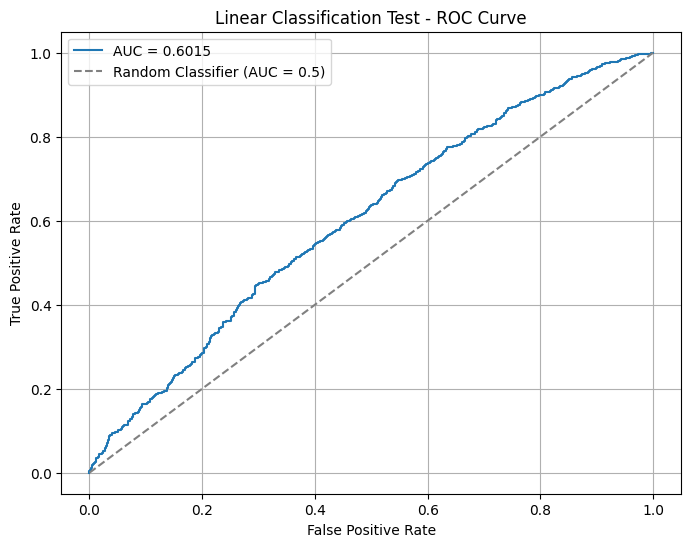

Confusion Matrix:
[[545 397]
 [408 525]]


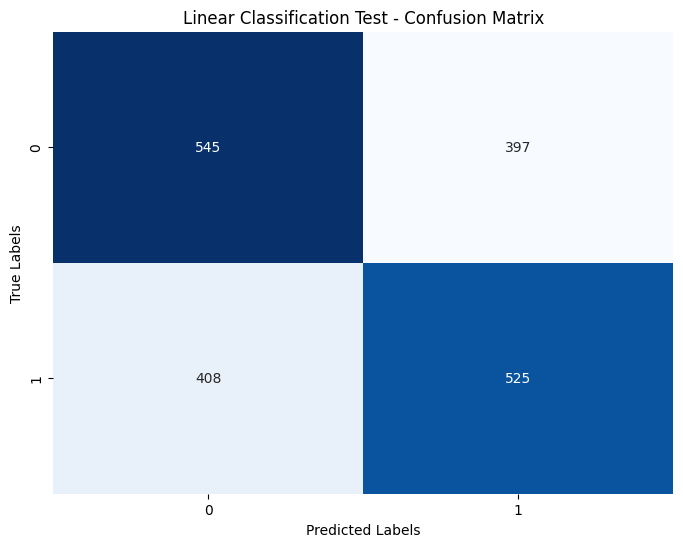

In [31]:
## Linear Classification Test
# Train a simple linear classifier (Logistic Regression)
classifier = LogisticRegression(max_iter=1000)
classifier.fit(X_train, y_train)

# Predict on test set
y_pred = classifier.predict(X_test)

# Compute accuracy of the linear classifier
accuracy = accuracy_score(y_test, y_pred)
print(f"Linear Classifier Test Accuracy: {accuracy * 100:.2f}%")
wandb.log({"Linear Classifier Test Accuracy": f"{accuracy * 100:.2f}%"})

# Compute the AUC score and plot the ROC curve
if len(np.unique(y_test)) == 2:  # Binary classification
    y_prob = classifier.predict_proba(X_test)[:, 1]  # Probability estimates for the positive class
    auc_score = roc_auc_score(y_test, y_prob)
    print(f"AUC Score: {auc_score:.4f}")

    # Plot ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f"AUC = {auc_score:.4f}")
    
    # Add the diagonal line representing random guessing
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random Classifier (AUC = 0.5)")
    
    # Label the plot
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Linear Classification Test - ROC Curve")
    plt.legend()
    plt.grid(True)
    
    # Save and log the plot to WandB
    plt.savefig("roc_curve.png")
    wandb.log({"ROC Curve": wandb.Image("roc_curve.png")})
    
    # Show the plot (optional)
    plt.show()

# Compute and display the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Linear Classification Test - Confusion Matrix')

# Save and log the confusion matrix plot to WandB
plt.savefig("confusion_matrix.png")
wandb.log({"Confusion Matrix": wandb.Image("confusion_matrix.png")})

plt.show()

In [34]:
wandb.finish()

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
train_loss,██▇▆▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,██▇▆▄▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Linear Classifier Test Accuracy,57.07%
epoch,50
train_loss,0.00874
val_loss,0.17895
